In [1]:
from functools import partial
import os

import torch
import numpy as np
import gradio as gr
import random
import shutil

print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

import os
from os.path import join as pjoin

import torch.nn.functional as F

from models.mask_transformer.transformer import MaskTransformer, ResidualTransformer
from models.vq.model import RVQVAE, LengthEstimator

from options.hgdemo_option import EvalT2MOptions
from utils.get_opt import get_opt

from utils.fixseed import fixseed
from visualization.joints2bvh import Joint2BVHConvertor
from torch.distributions.categorical import Categorical

from utils.motion_process import recover_from_ric
from utils.plot_script import plot_3d_motion

from utils.paramUtil import t2m_kinematic_chain

from gen_t2m import load_vq_model, load_res_model, load_trans_model, load_len_estimator

clip_version = 'ViT-B/32'

Is CUDA available: True
CUDA device: NVIDIA RTX A4000


In [2]:
DEFAULT_TEXT = "A person is "


if not os.path.exists("/data/checkpoints/t2m"):
    os.system("bash prepare/download_models_demo.sh")
if not os.path.exists("checkpoints/t2m"):
    os.system("ln -s /data/checkpoints checkpoints")
if not os.path.exists("/data/stats"):
    os.makedirs("/data/stats")
    with open("/data/stats/Prompts.text", 'w') as f:
        pass

Total_Calls = 4730
def update_total_calls():
    global Total_Calls
    Total_Calls_offset = 4730 ## init number from visit, 01/07
    with open("/data/stats/Prompts.text", 'r') as f:
        Total_Calls = len(f.readlines()) + Total_Calls_offset
    print("Prompts Num:",Total_Calls)

--2024-04-24 15:01:24--  https://huggingface.co/nanxiz/zcabnzhmm/resolve/main/humanml3d_models.zip
Resolving huggingface.co (huggingface.co)... 143.204.55.124, 143.204.55.75, 143.204.55.121, ...
Connecting to huggingface.co (huggingface.co)|143.204.55.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/51/e5/51e5af682b7b348fd97734dce95f0eaaa8e57c164cb802264e0953a78549872e/3ed737fe352c4cdc671b0c133d6c0090690468d58832bd883686188d5f333ec7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27humanml3d_models.zip%3B+filename%3D%22humanml3d_models.zip%22%3B&response-content-type=application%2Fzip&Expires=1714230084&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDIzMDA4NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzUxL2U1LzUxZTVhZjY4MmI3YjM0OGZkOTc3MzRkY2U5NWYwZWFhYThlNTdjMTY0Y2I4MDIyNjRlMDk1M2E3ODU0OTg3MmUvM2VkNzM3ZmUzNTJjNGNkYzY3MW

Archive:  humanml3d_models.zip
   creating: length_estimator/
   creating: length_estimator/model/
  inflating: length_estimator/model/finest.tar  
   creating: rvq_nq6_dc512_nc512_noshare_qdp0.2/
   creating: rvq_nq6_dc512_nc512_noshare_qdp0.2/meta/
   creating: rvq_nq6_dc512_nc512_noshare_qdp0.2/model/
  inflating: rvq_nq6_dc512_nc512_noshare_qdp0.2/opt.txt  
  inflating: rvq_nq6_dc512_nc512_noshare_qdp0.2/meta/mean.npy  
  inflating: rvq_nq6_dc512_nc512_noshare_qdp0.2/meta/std.npy  
  inflating: rvq_nq6_dc512_nc512_noshare_qdp0.2/model/net_best_fid.tar  
   creating: t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns/
   creating: t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns/model/
  inflating: t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns/opt.txt  
  inflating: t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns/model/latest.tar  
   creating: tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw/
   creating: tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw/model/
  inflating: tres_nlayer8_ld384_ff1024_rvq6

In [3]:
# 设置参数
which_epoch = "latest"
batch_size = 32
ext = 'text2motion'
num_batch = 2
repeat_times = 1
cond_scale = 4
temperature = 1.0
topkr = 0.9
time_steps = 18
seed = 10107
gumbel_sample = False
use_res_model = False
res_name = 'tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw'
text_path = ""
mask_edit_section = None
text_prompt = ''
source_motion = 'example_data/000612.npy'
motion_length = 0

# 设置选项
opt = {
    'which_epoch': which_epoch,
    'batch_size': batch_size,
    'ext': ext,
    'num_batch': num_batch,
    'repeat_times': repeat_times,
    'cond_scale': cond_scale,
    'temperature': temperature,
    'topkr': topkr,
    'time_steps': time_steps,
    'seed': seed,
    'gumbel_sample': gumbel_sample,
    'use_res_model': use_res_model,
    'res_name': res_name,
    'text_path': text_path,
    'mask_edit_section': mask_edit_section,
    'text_prompt': text_prompt,
    'source_motion': source_motion,
    'motion_length': motion_length,
    'is_train': False,
    'checkpoints_dir': './checkpoints',
    'dataset_name': 't2m',
    'name': 't2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns'
}

opt = {
    'name': 't2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns',
    'vq_name': 'rvq_nq1_dc512_nc512',
    'gpu_id': 0,
    'dataset_name': 't2m',
    'checkpoints_dir': './checkpoints',
    'latent_dim': 384,
    'n_heads': 6,
    'n_layers': 8,
    'ff_size': 1024,
    'dropout': 0.2,
    'max_motion_length': 196,
    'unit_length': 4,
    'force_mask': False,
    'which_epoch': 'latest',
    'batch_size': 32,
    'ext': 'text2motion',
    'num_batch': 2,
    'repeat_times': 1,
    'cond_scale': 4,
    'temperature': 1.0,
    'topkr': 0.9,
    'time_steps': 18,
    'seed': 10107,
    'gumbel_sample': False,
    'use_res_model': False,
    'res_name': 'tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw',
    'text_path': '',
    'mask_edit_section': None,
    'text_prompt': '',
    'source_motion': 'example_data/000612.npy',
    'motion_length': 0,
    'is_train': False,
}

In [4]:
opt['device']= torch.device("cpu" if opt['gpu_id'] == -1 else "cuda:" + str(opt['gpu_id']))


In [5]:
opt['device']

device(type='cuda', index=0)

In [6]:
fixseed(opt['seed'])
opt['device'] = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
dim_pose = 263
root_dir = pjoin(opt['checkpoints_dir'], opt['dataset_name'], opt['name'])
model_dir = pjoin(root_dir, 'model')
model_opt_path = pjoin(root_dir, 'opt.txt')
model_opt = get_opt(model_opt_path, device=opt['device'])

Reading ./checkpoints/t2m/t2m_nlayer8_nhead6_ld384_ff1024_cdp0.1_rvq6ns/opt.txt


In [7]:
######Loading RVQ######
vq_opt_path = pjoin(opt['checkpoints_dir'], opt['dataset_name'], model_opt.vq_name, 'opt.txt')
vq_opt = get_opt(vq_opt_path, device=opt['device'])
vq_opt.dim_pose = dim_pose
vq_model, vq_opt = load_vq_model(vq_opt)

model_opt.num_tokens = vq_opt.nb_code
model_opt.num_quantizers = vq_opt.num_quantizers
model_opt.code_dim = vq_opt.code_dim

Reading ./checkpoints/t2m/rvq_nq6_dc512_nc512_noshare_qdp0.2/opt.txt
Loading VQ Model rvq_nq6_dc512_nc512_noshare_qdp0.2 Completed!


In [8]:
def load_res_model(res_opt, vq_opt, opt):
    res_opt.num_quantizers = vq_opt.num_quantizers
    res_opt.num_tokens = vq_opt.nb_code
    res_transformer = ResidualTransformer(code_dim=vq_opt.code_dim,
                                          cond_mode='text',
                                          latent_dim=res_opt.latent_dim,
                                          ff_size=res_opt.ff_size,
                                          num_layers=res_opt.n_layers,
                                          num_heads=res_opt.n_heads,
                                          dropout=res_opt.dropout,
                                          clip_dim=512,
                                          shared_codebook=vq_opt.shared_codebook,
                                          cond_drop_prob=res_opt.cond_drop_prob,
                                          share_weight=res_opt.share_weight,
                                          clip_version=clip_version,
                                          opt=res_opt)

    ckpt = torch.load(pjoin(res_opt.checkpoints_dir, res_opt.dataset_name, res_opt.name, 'model', 'net_best_fid.tar'),
                      map_location=opt['device'])
    missing_keys, unexpected_keys = res_transformer.load_state_dict(ckpt['res_transformer'], strict=False)
    assert len(unexpected_keys) == 0
    assert all([k.startswith('clip_model.') for k in missing_keys])
    print(f'Loading Residual Transformer {res_opt.name} from epoch {ckpt["ep"]}!')
    return res_transformer

######Loading R-Transformer######
res_opt_path = pjoin(opt['checkpoints_dir'], opt['dataset_name'], opt['res_name'], 'opt.txt')
res_opt = get_opt(res_opt_path, device=opt['device'])
res_model = load_res_model(res_opt, vq_opt, opt)

assert res_opt.vq_name == model_opt.vq_name



Reading ./checkpoints/t2m/tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw/opt.txt
latent_dim: 384, ff_size: 1024, nlayers: 8, nheads: 6, dropout: 0.2
Loading CLIP...
Loading Residual Transformer tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw from epoch 440!


In [9]:
def load_trans_model(model_opt, opt, which_model):
    t2m_transformer = MaskTransformer(code_dim=model_opt.code_dim,
                                      cond_mode='text',
                                      latent_dim=model_opt.latent_dim,
                                      ff_size=model_opt.ff_size,
                                      num_layers=model_opt.n_layers,
                                      num_heads=model_opt.n_heads,
                                      dropout=model_opt.dropout,
                                      clip_dim=512,
                                      cond_drop_prob=model_opt.cond_drop_prob,
                                      clip_version=clip_version,
                                      opt=model_opt)
    ckpt = torch.load(pjoin(model_opt.checkpoints_dir, model_opt.dataset_name, model_opt.name, 'model', which_model),
                      map_location='cpu')
    model_key = 't2m_transformer' if 't2m_transformer' in ckpt else 'trans'
    # print(ckpt.keys())
    missing_keys, unexpected_keys = t2m_transformer.load_state_dict(ckpt[model_key], strict=False)
    assert len(unexpected_keys) == 0
    assert all([k.startswith('clip_model.') for k in missing_keys])
    #print(f'Loading Transformer {opt['name']} from epoch {ckpt["ep"]}!')
    return t2m_transformer



######Loading M-Transformer######
t2m_transformer = load_trans_model(model_opt, opt, 'latest.tar')

latent_dim: 384, ff_size: 1024, nlayers: 8, nheads: 6, dropout: 0.2
Loading CLIP...


In [10]:
def load_len_estimator(opt):
    model = LengthEstimator(512, 50)
    ckpt = torch.load(pjoin(opt['checkpoints_dir'], opt['dataset_name'], 'length_estimator', 'model', 'finest.tar'),
                      map_location=opt['device'])
    model.load_state_dict(ckpt['estimator'])
    print(f'Loading Length Estimator from epoch {ckpt["epoch"]}!')
    return model

def load_len_estimator(opt):
    opt_dict = vars(opt)
    model = LengthEstimator(512, 50)
    ckpt = torch.load(pjoin(opt_dict['checkpoints_dir'], opt_dict['dataset_name'], 'length_estimator', 'model', 'finest.tar'),
                      map_location=opt_dict['device'])
    model.load_state_dict(ckpt['estimator'])
    print(f'Loading Length Estimator from epoch {ckpt["epoch"]}!')
    return model

#####Loading Length Predictor#####
length_estimator = load_len_estimator(model_opt)

Loading Length Estimator from epoch 11!


In [11]:
t2m_transformer.eval()
vq_model.eval()
res_model.eval()
length_estimator.eval()

res_model.to(opt['device'])
t2m_transformer.to(opt['device'])
vq_model.to(opt['device'])
length_estimator.to(opt['device'])

opt['nb_joints'] = 22
mean = np.load(pjoin(opt['checkpoints_dir'], opt['dataset_name'], model_opt.vq_name, 'meta', 'mean.npy'))
std = np.load(pjoin(opt['checkpoints_dir'], opt['dataset_name'], model_opt.vq_name, 'meta', 'std.npy'))
def inv_transform(data):
    return data * std + mean

kinematic_chain = t2m_kinematic_chain
converter = Joint2BVHConvertor()
cached_dir = './cached'
uid = 12138
animation_path = pjoin(cached_dir, f'{uid}')
os.makedirs(animation_path, exist_ok=True)

In [12]:
text_prompt = "A person is running on a treadmill."


In [12]:
length_list = []
length_list.append(20*20)
token_lens = torch.LongTensor(length_list) // 4
token_lens = token_lens.to(opt['device']).long()

prompt_list = []
prompt_list.append("a person is standing")

/tmp/ipykernel_5667/3063627277.py:3: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  token_lens = torch.LongTensor(length_list) // 4


In [13]:
captions = prompt_list
mids = t2m_transformer.generate(captions, token_lens,
                                        timesteps=opt['time_steps'],
                                        cond_scale=opt['cond_scale'],
                                        temperature=opt['temperature'],
                                        topk_filter_thres=opt['topkr'],
                                        gsample=opt['gumbel_sample'])

In [14]:
mids

tensor([[ 98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
          98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
          98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
          98,  98,  98,  98,  98,  98,  98, 301,  98,  98,  98,  98,  98,  98,
          98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
          98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
          98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,  98,
          98,  98]], device='cuda:0')

In [15]:
mids = res_model.generate(mids, captions, token_lens, temperature=1, cond_scale=5)
mids

tensor([[[ 98,  95, 465,  24, 326, 315],
         [ 98,  50,  72, 372, 187,  29],
         [ 98,  50, 267, 309,  20, 431],
         [ 98, 317, 237,  20, 313, 404],
         [ 98,  50, 386, 348, 223, 159],
         [ 98, 292, 470, 333, 273, 410],
         [ 98,  21, 381,  94,  14, 182],
         [ 98, 362, 277, 264, 141, 268],
         [ 98,  50, 386, 248, 431, 241],
         [ 98,  50, 455, 109,  75, 268],
         [ 98,  50, 313, 324,  18, 409],
         [ 98, 155, 394, 372, 228,  35],
         [ 98, 155, 326, 333, 273, 160],
         [ 98, 317, 127,  12,  80, 177],
         [ 98, 470, 291,  85, 433, 213],
         [ 98, 192,  67, 308,  80, 393],
         [ 98, 374, 394, 442,  82, 392],
         [ 98,  50, 510, 187, 502, 431],
         [ 98,  24, 313,  24, 152,  38],
         [ 98,  24, 465, 467, 270, 481],
         [ 98, 470, 465,  61, 100, 223],
         [ 98, 230, 174, 494, 187, 268],
         [ 98,  50, 469, 119,  18, 222],
         [ 98, 193, 394, 171, 166, 231],
         [ 98,  

In [16]:
pred_motions = vq_model.forward_decoder(mids)
pred_motions = pred_motions.detach().cpu().numpy()
pred_motions

array([[[-1.4972293e-02, -1.2075394e+00, -9.2680941e+00, ...,
          9.9033127e+00,  1.0832652e+01,  9.9400253e+00],
        [ 8.4302343e-02, -1.0337877e+00, -8.5104065e+00, ...,
          9.9766827e+00,  1.0842822e+01,  9.9246740e+00],
        [ 3.3904947e-02, -1.2336304e+00, -7.6083326e+00, ...,
          9.9638700e+00,  1.0820645e+01,  9.9555483e+00],
        ...,
        [-5.8057100e-01, -6.1945021e-01, -1.4850858e+01, ...,
          1.0017403e+01,  1.0854435e+01,  9.9575338e+00],
        [-4.8925194e-01, -7.8757054e-01, -1.5009091e+01, ...,
          9.9623070e+00,  1.0800048e+01,  9.9506798e+00],
        [-7.3621476e-01, -4.5476922e-01, -1.5144826e+01, ...,
          9.9348698e+00,  1.0786458e+01,  9.9069395e+00]]], dtype=float32)

In [17]:
pred_motions.shape

(1, 400, 263)

In [35]:
@torch.no_grad()
def generate(text, uid, motion_length=0, use_ik=True, seed=10107, repeat_times=1):
    # fixseed(seed)
    print(text)
    prompt_list = []
    length_list = []
    est_length = False
    prompt_list.append(text)
    if motion_length == 0:
        est_length = True
    else:
        length_list.append(motion_length)

    if est_length:
        print("Since no motion length are specified, we will use estimated motion lengthes!!")
        text_embedding = t2m_transformer.encode_text(prompt_list)
        pred_dis = length_estimator(text_embedding)
        probs = F.softmax(pred_dis, dim=-1)  # (b, ntoken)
        token_lens = Categorical(probs).sample()  # (b, seqlen)
    else:
        token_lens = torch.LongTensor(length_list) // 4
        token_lens = token_lens.to(opt['device']).long()

    m_length = token_lens * 4
    captions = prompt_list
    datas = []
    for r in range(repeat_times):
        mids = t2m_transformer.generate(captions, token_lens,
                                        timesteps=opt['time_steps'],
                                        cond_scale=opt['cond_scale'],
                                        temperature=opt['temperature'],
                                        topk_filter_thres=opt['topkr'],
                                        gsample=opt['gumbel_sample'])
                                        #max_motion_length = 400)
        mids = res_model.generate(mids, captions, token_lens, temperature=1, cond_scale=5)
        pred_motions = vq_model.forward_decoder(mids)
        pred_motions = pred_motions.detach().cpu().numpy()
        data = inv_transform(pred_motions)
        ruid = random.randrange(999999999)

        
        animation_path = pjoin(cached_dir, f'{uid}')
        np.save(pjoin(animation_path, "sample_repeat263motion%d.npy"%(r)), np.squeeze(data))

        

        for k, (caption, joint_data)  in enumerate(zip(captions, data)):
            #animation_path = pjoin(cached_dir, f'{uid}')
            os.makedirs(animation_path, exist_ok=True)
            joint_data = joint_data[:m_length[k]]
            joint = recover_from_ric(torch.from_numpy(joint_data).float(), 22).numpy()
            bvh_path = pjoin(animation_path, "sample_repeat%d.bvh" % (r))
            save_path = pjoin(animation_path, "sample_repeat%d_%d.mp4"%(r, ruid))
            if use_ik:
                print("Using IK")
                _, joint = converter.convert(joint, filename=bvh_path, iterations=100)
            else:
                _, joint = converter.convert(joint, filename=bvh_path, iterations=100, foot_ik=False)
            plot_3d_motion(save_path, kinematic_chain, joint, title=caption, fps=20)
            np.save(pjoin(animation_path, "sample_repeat%d.npy"%(r)), joint)
        data_unit = {
            "url": pjoin(animation_path, "sample_repeat%d_%d.mp4"%(r, ruid))
            }
        datas.append(data_unit)


    return data, datas, joint, pred_motions

# 示例文本
text_prompt = "A person is standing."

# 生成结果
data,datas,joint,pred_motions = generate(text_prompt, uid, motion_length=10*20, use_ik=True)

# 打印生成结果的URL
#for data in datas:
#    print(data['url'])

A person is standing.


/tmp/ipykernel_5667/3512901884.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  token_lens = torch.LongTensor(length_list) // 4


Using IK


In [30]:
data.shape

(1, 200, 263)

In [31]:
pred_motions.shape

(1, 200, 263)

In [20]:
joint.shape

(200, 22, 3)

In [33]:
aa = np.load("example_data/000612.npy")

In [34]:
aa.shape

(199, 263)

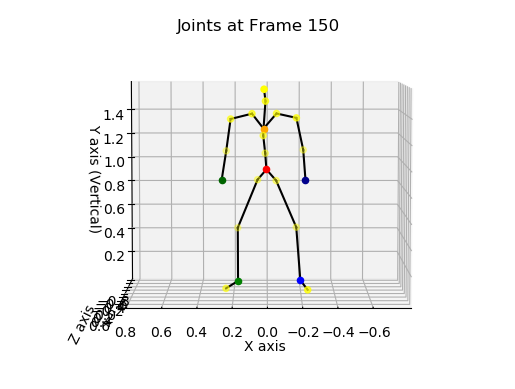

In [68]:
plot_joints_sticks(joint,[[0] for _ in range(400)],150)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def plot_joints_sticks(motion_data, quat_data, frame_index, stick_length=0.1, show_sticks = False):
    if frame_index < 0 or frame_index >= motion_data.shape[0]:
        raise ValueError("Frame index out of range.")

    joint_positions = motion_data[frame_index]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates
    x = joint_positions[:, 0]
    y = joint_positions[:, 1]
    z = joint_positions[:, 2]

    quaternions = quat_data[frame_index]

    # Define special joints and their colors
    special_joints_colors = {
        0: 'red',    # Joint 0 in red
        9: 'orange', # Joint 12 in orange
        7: 'green',  # Joints 7, 8, 20, 21 in green 左边
        8: 'blue',
        20: 'darkgreen',
        21: 'darkblue'
    }

    # Plot special joints
    for joint, color in special_joints_colors.items():
        ax.scatter(x[joint], z[joint], y[joint], c=color)
        if show_sticks:
            plot_stick(ax, x[joint], y[joint], z[joint], quaternions[joint], stick_length, color)

    # Plot other joints
    other_joints = [j for j in range(22) if j not in special_joints_colors]
    ax.scatter(x[other_joints], z[other_joints], y[other_joints], c='yellow')
    if show_sticks:
        for joint in other_joints:
            plot_stick(ax, x[joint], y[joint], z[joint], quaternions[joint], stick_length)

    # Plot lines connecting each joint to its parent
    parents = [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 12, 13, 14, 16, 17, 18, 19]
    for idx, parent in enumerate(parents):
        if parent != -1:  # Check to avoid drawing a line for the root joint
            ax.plot([x[idx], x[parent]], [z[idx], z[parent]], [y[idx], y[parent]], color='black')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Z axis')
    ax.set_zlabel('Y axis (Vertical)')
    
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+0) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)

    # Rotate the plot for a better view
    ax.view_init(elev=5., azim=90)

    ax.set_title(f'Joints at Frame {frame_index}')

    plt.show()

def plot_stick(ax, x, y, z, quaternion, length, color='gray'):
    # Convert quaternion to a rotation vector
    rot_vec = R.from_quat([quaternion[1],quaternion[2],quaternion[3],quaternion[0]]).apply([length, 0, 0])

    # Plot a line (stick) in the direction of the rotation vector
    ax.plot([x, x + rot_vec[0]], [z, z + rot_vec[2]], [y, y + rot_vec[1]], color=color)

In [10]:
which_epoch = "latest"  # Checkpoint you want to use, {latest, net_best_fid, etc}
batch_size = 32  # Batch size
ext = 'text2motion'  # Extension of the result file or folder

num_batch = 2  # Number of batch for generation
repeat_times = 1  # Number of repetitions, per sample text prompt
cond_scale = 4  # For classifier-free sampling - specifies the s parameter, as defined in the paper.
temperature = 1.  # Sampling Temperature
topkr = 0.9  # Filter out percentil low prop entries.
time_steps = 18  # Mask Generate steps.
seed = 10107

gumbel_sample = False  # True: gumbel sampling, False: categorical sampling.
use_res_model = False  # Whether to use residual transformer.

res_name = 'tres_nlayer8_ld384_ff1024_rvq6ns_cdp0.2_sw'  # Model name of residual transformer
text_path = ""  # Text prompt file

mask_edit_section = None  # Indicate sections for editing, use comma to separate the start and end of a section

text_prompt = ''  # A text prompt to be generated. If empty, will take text prompts from dataset.
source_motion = 'example_data/000612.npy'  # Source motion path for editing. (new_joint_vecs format .npy file)
motion_length = 0  # Motion length for generation, only applicable with single text prompt.

is_train = False
